In [2]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [3]:
from keras.models import model_from_json
from skimage.transform import resize


In [4]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename, verbose=False): 
    if verbose:
        print(f'Loading file: {filename} ...')
    
    dcm = pydicom.dcmread(filename)       
    
    if verbose:
        print(dcm)
        print(f'ID: {dcm.PatientID}')
        print(f'Sex: {dcm.PatientSex}')
        print(f'Age: {dcm.PatientAge}')
        print(f'Modality: {dcm.Modality}')
        print(f'Study Description: {dcm.StudyDescription}')
        print(f'Rows: {dcm.Rows}')
        print(f'Columns: {dcm.Columns}')
        
    # Age
    age = int(dcm.PatientAge)
    if age < 2 or age > 90:
        print(f'Image {filename} rejected, Age: {age}')
        return None
    
    # Body Part
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Body part: {body_part}')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position: {pos}')
        return None
    
    return dcm.pixel_array
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_mean, img_std, img_size, verbose=False): 
    
    if verbose:
        print(f'Image data: {img.shape}')
        
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)

    if verbose:
        print(f'Resized data: {resized_img.shape}')

    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)

    if verbose:
        print(f'Processed data: {proc_img.shape}')

    return proc_img


# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)

    # load weights into new model
    model.load_weights(weight_path)
    print(f"Model loaded: {model}")
    
    return model


# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    
    pred = model.predict(img)
    prediction = pred > thresh
    
    # batch size: 1, single output
    return prediction[0][0]


def show_image_distr(img):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()


Loading file: test1.dcm ...
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROM

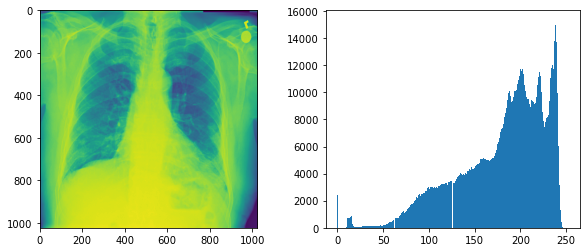

In [5]:
img_example = check_dicom('test1.dcm', verbose=True)
show_image_distr(img_example)

Image data: (1024, 1024)
Resized data: (224, 224)
Processed data: (1, 224, 224, 3)


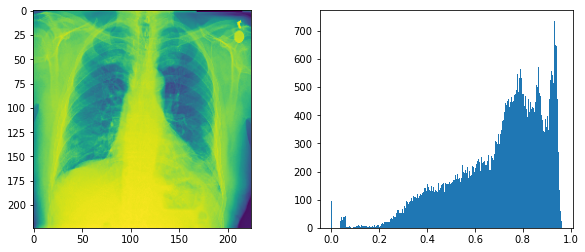

In [6]:
img_example_proc = preprocess_image(img_example, -1, -1, (1, 224, 224, 3), verbose=True)[0, :, :, 0]
show_image_distr(img_example_proc)

In [7]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'xray_final_model.json'
weight_path = 'xray_classification_model.best.hdf5'

# VGG16
IMG_SIZE=(1,224,224,3)  

# Mean & std passed from outside not used
# Resize function used in preprocessing normalizes the image data automatically 
img_mean = -1           
img_std = -1

my_model = load_model(model_path, weight_path) 
thresh = 0.3                                   

def predict_dicom(filename):
    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return None
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    return pred


Model loaded: <keras.engine.sequential.Sequential object at 0x7f5faba1b650>


In [8]:
def show_image_pred(img, filename, pred):
    plt.imshow(img, cmap='gray')
    plt.title(f'{filename}, prediction: {pred}')
    plt.show()

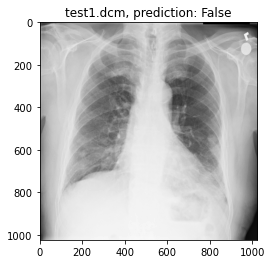

In [9]:
img_example_pred = predict_dicom('test1.dcm')
show_image_pred(img_example, 'test1.dcm', img_example_pred)

Image test4.dcm rejected, Body part: RIBCAGE
Image test6.dcm rejected, Patient position: XX


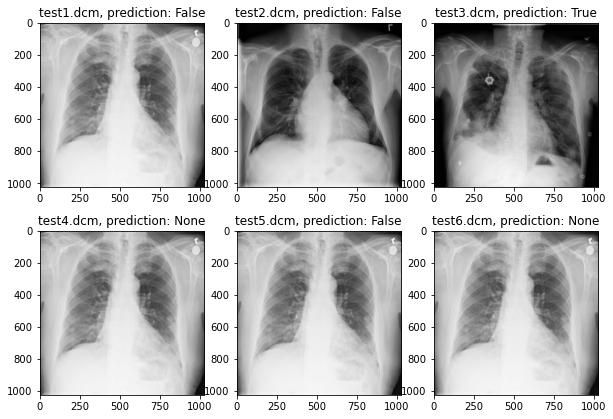

In [11]:
# use the .dcm files to test your prediction

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
    
for i,filename in enumerate(test_dicoms):
    pred = predict_dicom(filename)
    
    img = pydicom.dcmread(filename).pixel_array        
    
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')

plt.show()    
    